### Error Analysis   

In this notebook, we are going to conduct error analysis over the trained CatBoost model. We will firstly have an overview on the error distribution of our model. Then we will look into details on sampled records to investigate the error in relationship with feature importance driving for the prediction results.  


In [1]:
import pandas as pd 
import numpy as np
import datetime 
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import altair as alt 
from altair import datum
# shap 0.39 requires matplotlib 3.4.3 for plotting correctly 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import shap
shap.initjs()

import tempfile
from IPython.core.display import display, HTML

RANDOM_STATE = 42

### Data Preparation 

In [2]:
# Load vessel data
df_vessel = pd.read_csv('./data/cleansed/vessel_dwell_time.csv')
df_vessel['time_seen'] = pd.to_datetime(df_vessel['time_seen'])
X = df_vessel.drop(columns=[ 'imo', 'vessel_name', 'time_seen', 'vessel_type', 'dwell_in_hr'])
y = df_vessel['dwell_in_hr']

In [3]:
# create training set and testing set
# CatBoost has built-in support for categorical data. We are not required to handle it seperately
categorical_features_indices = [0,6,7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# create data pool for training set. Pool is specific to CatBoost
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

(1307, 11) (327, 11) (1307,) (327,)


In [4]:
model = CatBoostRegressor().load_model('./model/catboost_20221009.cbm')

### Study Overall Error Distribution 

In [5]:
df_test_result = X_test.copy()
df_test_result['dwell_in_hr'] = y_test
df_test_result['predict_dwell'] = model.predict(X_test)
df_test_result['predict_error'] = df_test_result['predict_dwell'] - df_test_result['dwell_in_hr']
df_test_result['percent_error'] = ((df_test_result['predict_dwell'] - df_test_result['dwell_in_hr']) / df_test_result['dwell_in_hr']).round(3)
df_test_result = pd.merge(df_test_result, df_vessel['time_seen'], how='left', left_index=True, right_index=True)

In [6]:
# A helper function to calcuate the percentage of error within a day range
def percent_of_error_within_day_range(data, day_range):

    def is_error_within_day_range(data, day_range):
        if abs(data/24) <= day_range:
            return True
        else:
            return False

    result = data['predict_error'].apply(lambda x: is_error_within_day_range(x, day_range)).value_counts()
    return round(result[result.index==True].iloc[0] / len(data), 3)

In [7]:
alt.Chart(data=df_test_result).mark_bar(color='lightblue').encode(
    #alt.X('dwell_in_hr:Q', bin=alt.Bin(binned=True)),
    x=alt.X('predict_error:Q', bin=alt.Bin(step=24)),
    #extent=[0, 500]
    y='count()'
).properties(
    width=800,
    height=300,
    title='Prediction Error Histogram binned by 24hrs interval'
)#.interactive()

alt.Chart(...)

In [8]:
poe = percent_of_error_within_day_range(df_test_result, 1)
print(f'{poe*100}% of errors are witin plus or minus 1 day')

poe = percent_of_error_within_day_range(df_test_result, 2)
print(f'{poe*100}% of errors are witin plus or minus 2 day')

poe = percent_of_error_within_day_range(df_test_result, 3)
print(f'{poe*100}% of errors are witin plus or minus 3 day')

63.9% of errors are witin plus or minus 1 day
72.2% of errors are witin plus or minus 2 day
82.0% of errors are witin plus or minus 3 day


Overall, our model performs not bad. Around 64% of errors are within plus or minus 1 day, while around 72% of errors are within plus or minus 2 days. For downstream logistic service providers in preparing for container pickup, this range of error sounds acceptable. 


Next we'll look into the errors in more detail. Firstly, we'll have an overview on errors for all test data.

In [9]:
# create a bar plot for all prediction errors
alt.Chart(data=df_test_result).mark_bar().encode(
    #alt.X('dwell_in_hr:Q', bin=alt.Bin(binned=True)),
    x=alt.X('time_seen:T'),
    #extent=[0, 500]
    #y=alt.Y('max(predict_error):Q'),
    y=alt.Y('predict_error:Q'),
    color=alt.condition(
        alt.datum.predict_error > 0,
        alt.value("steelblue"),  # The positive color
        alt.value("orange")  # The negative color
    ),
    tooltip=[
        'time_seen:T',
        'vessel_name:N',
        'target_terminal:N'
    ]
).properties(
    width=800,
    height=350,
    title='Prediction Error Bar Plot'
)#.interactive()

alt.Chart(...)

This is eye-catching for the significant underestimating of dwell time in the period of Oct to Dec 2021.  
We’ll take a look at the dwell time across the whole data set (both training and test) to see any special thing for this period. 

In [10]:
# Create a bar plot for dwell time across the whole data set (both training and test)
alt.Chart(data=df_vessel).mark_bar(color='lightblue').encode(
    #alt.X('dwell_in_hr:Q', bin=alt.Bin(binned=True)),
    x=alt.X('time_seen:T'),
    #extent=[0, 500]
    #y=alt.Y('max(predict_error):Q'),
    y=alt.Y('dwell_in_hr:Q'),
    tooltip=[
        'time_seen:T',
        'vessel_name:N',
        'target_terminal:N'
    ]
).properties(
    width=800,
    height=300,
    title='Dwell Time Bar Plot (2020 to mid-2022)'
)#.interactive()

alt.Chart(...)

Obviously, the period of Oct to Dec 2021 is abnormal. We can see dwell times spike significantly during this time of year. In fact, the supply chains and port congestion in the late 2021 and early 2022 are well known. This was mainly caused by an excessive backlog of cargo in the East due to the pandemic.    

Anyways, our model doesn’t work well for this abnormal period and we’ll find out why. But before that, we will take a look at the model behavior focusing on feature importance. 


### Model Feature Importance

We'll use shapley value to measure feature importance of a model

In [11]:
"""
Helper function to plot the summary plot for categorical feature

  Parameters:
    data: data set used to calculate shap values 
    shap_values: the shap_values returned by shap explainer
    feature_name: the feature we are targetting 
  
  Output:
    shap summry plot for categorical feature 
""" 
def categorical_feature_summary_plot(data, shap_values, feature_name):
    
    col_data = data[feature_name]
    col_shap_value = shap_values[:,data.columns.to_list().index(feature_name)]

    df = pd.DataFrame(col_data)
    df['shape_value'] = col_shap_value

    #print(f'Shape before pivot: {df.shape}')
    df = df.pivot(columns=feature_name).reset_index(drop=True)
    df.columns = df.columns.droplevel(0)
    #print(f'Shape after pivot: {df.shape}')

    shap_values = df.values
    shap_cols = df.columns.to_list()
    return shap.summary_plot(shap_values=shap_values, feature_names=shap_cols, max_display=50)

In [12]:
# create explainer object and get the shap values over the test set
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_pool)

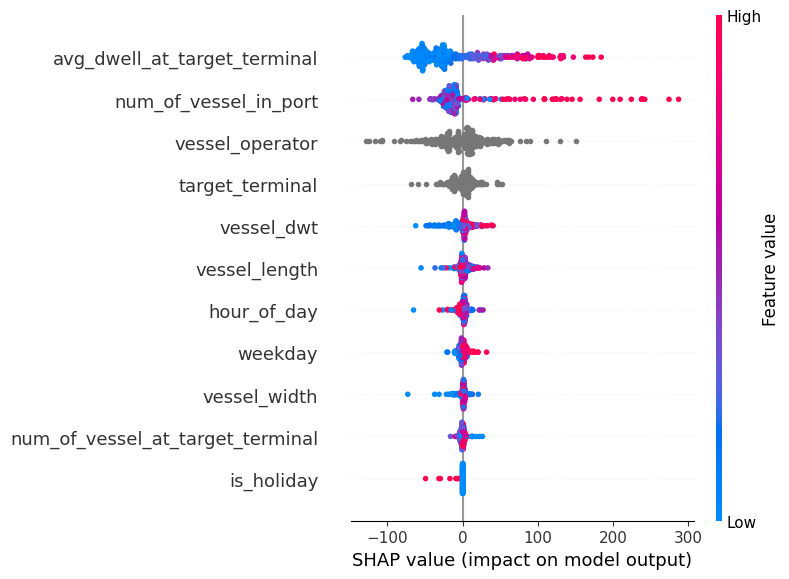

In [13]:
# plot the beeswarm plot for overall feature importance 
shap.summary_plot(shap_values, X_test)


The above beeswarm plot tells us the feature importance with respect to our model. It ranks the importance in descending order. Obviously, the `avg_dwell_at_target_terminal` and `num_of_vessel_in_port` are highly important to our model. Also, the higher these 2 values, the larger the shap value and hence the predicted value.   

`vessel_operator` and `target_terminal` are displayed in gray as they are categorical features. We’ll create a beeswarm plot for each of these. 

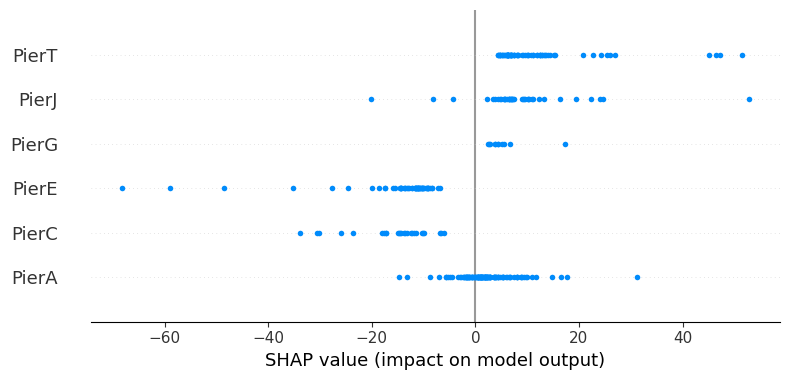

In [14]:
# beeswarm plot for target_terminal 
categorical_feature_summary_plot(X_test, shap_values, 'target_terminal')

Pier E and Pier C for `target_termnial` tend to push the prediction result smaller, i.e. lower dwell time. 

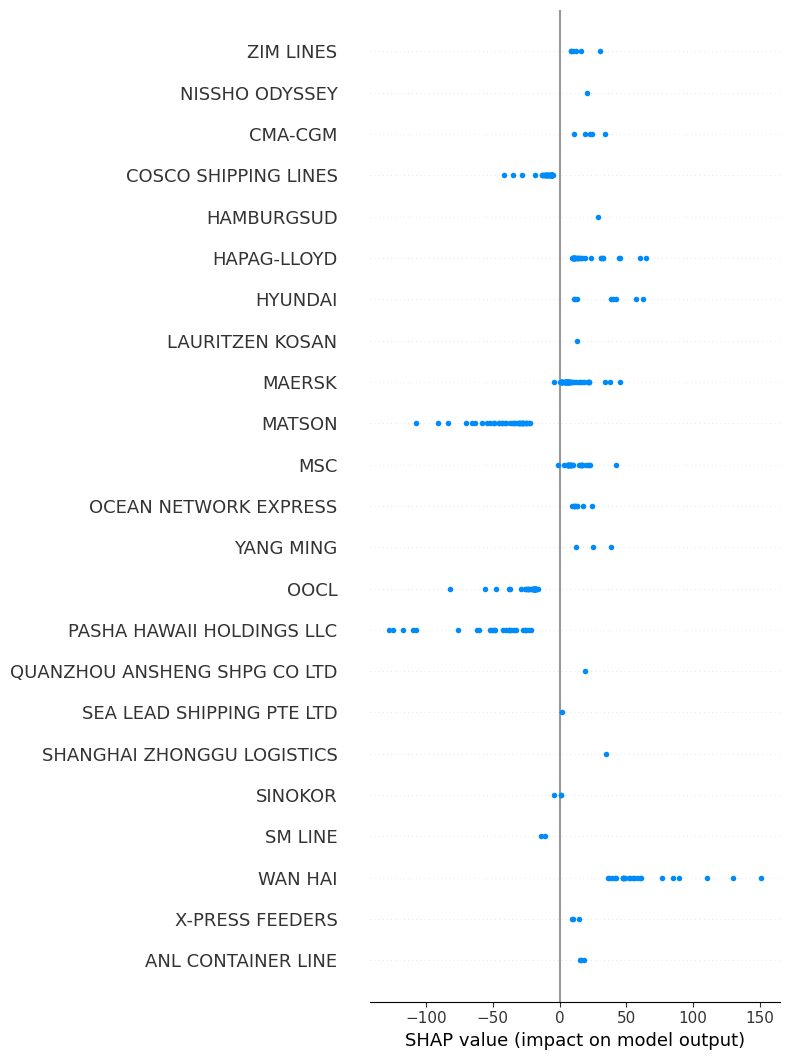

In [15]:
# beeswarem plot for vessel_operator
categorical_feature_summary_plot(X_test, shap_values, 'vessel_operator')

`vessel_operator` COSCO, Matson, OOCL and Pasha Hawaii tend to push the prediction result smaller, i.e. lower dwell time.  

Next, we'll look into the some data samples in problematic period (Oct and Nov of 2021) 

### Error Case Analysis

In [16]:
# create required data setup
df_result_21_10_11 = df_test_result[(df_test_result['time_seen']>='2021-10-1') & (df_test_result['time_seen']<='2021-11-30')]
df_result_21_10_11 = df_result_21_10_11.sort_values(by='predict_error', ascending=True)

In [17]:
"""
Helper function to get shap value and record of the test data base on the record index

  Parameters:
    shap_values: shap_values output from explainer on the test set
    test_data: test set fit to the explainer 
    record_index: the record index of test set dataframe we are interested 
  
  Output:
    shap values for the record we are interested
    record in the test set we are interested
"""
def get_shap_value_and_record_by_record_index(shap_values, test_data, record_index):
    row_index =  test_data.index.get_loc(test_data.loc[record_index:record_index].index[0])
    return shap_values[row_index,:], test_data.iloc[row_index,:]


"""
Helper function to print the shap force plot on a record

  Parameters:
    expected_value: the explainer.expected_value property 
    shap_values: shap_values output from explainer on the test set
    test_data: test set fit to the explainer 
    record_index: the record index of test set dataframe we are interested 
    show_record: print the record for debugging purpose. Default is False 
  
  Output:
    shap force plot object
"""
def get_force_plot(expected_value, shape_values, test_data, record_index, show_record=False):

    record_shap_value, record = get_shap_value_and_record_by_record_index(shap_values, test_data, record_index)

    if show_record == True:
        print(record)

    return shap.force_plot(explainer.expected_value, record_shap_value, record)


"""
Helper function to display shap force plot in DeepNote. 
This is a work around for showing shap force plot (and any javascript based plot of shap) in DeepNote
Source: https://deepnote.com/@joshzwiebel/Intro-to-SHAP-values-in-Python-7deb5572-c398-480f-9a21-11be6e6585ee

  Parameters:
    plot: shap force plot object
  
  Output:
    None
"""
def display_shap_js_plot_deepnote(plot):

    temp_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    shap.save_html(temp_filename, plot)

    f = open(temp_filename, 'r')
    data = f.read()
    display(HTML(data))


We firstly examine the top 3 underestimated records

In [18]:
df_result_21_10_11[['dwell_in_hr', 'predict_dwell', 'predict_error', 'percent_error', 'time_seen']].head(3)

,dwell_in_hr,predict_dwell,predict_error,percent_error,time_seen
1228,1212.0,59.035839,-1152.964161,-0.951,2021-10-04 13:03:07
1131,1513.2,512.752032,-1000.447968,-0.661,2021-11-20 23:49:14
1185,1426.5,533.604145,-892.895855,-0.626,2021-10-10 03:00:03


#### Case 1 [Record Index: 1228. Prediction Error: -1152.96 hours]

In [19]:
df_result_21_10_11[['dwell_in_hr', 'predict_dwell', 'predict_error', 'percent_error', 'time_seen']].iloc[[0]]

,dwell_in_hr,predict_dwell,predict_error,percent_error,time_seen
1228,1212.0,59.035839,-1152.964161,-0.951,2021-10-04 13:03:07


In [20]:
record_index = 1228
print(f'Record {record_index}')
force_plot = get_force_plot(explainer.expected_value, shap_values, X_test, record_index)
display_shap_js_plot_deepnote(force_plot)


Record 1228


Record 1228  is highly underestimated at around 95%, With a reference to the feature importance charts in the earlier section, we know both the `avg_dwell_at_target_termainl` and the `num_of_vessel_in_port` are  the two most important features for our model and they are positive correlated to predicted dwell time. However, in this case, their impacts are offset by  `vessel operator = COSCO` and `target_terminal = PierE`. These two features have significant -ve shap values, which means they push the prediction result lower. Overall, we can believe this is an exceptional case for `vessel_operator = COSCO` and `target_terminal = PierE` which normally should have a lower dwell time. 

#### Case 2: [Record Index: 1131. Prediction Error: -1000.44 hours]

In [21]:
df_result_21_10_11[['dwell_in_hr', 'predict_dwell', 'predict_error', 'percent_error', 'time_seen']].iloc[[1]]

,dwell_in_hr,predict_dwell,predict_error,percent_error,time_seen
1131,1513.2,512.752032,-1000.447968,-0.661,2021-11-20 23:49:14


In [22]:
record_index = 1131
print(f'Record {record_index}')
force_plot = get_force_plot(explainer.expected_value, shap_values, X_test, 1131)
display_shap_js_plot_deepnote(force_plot)

Record 1131


According to the feature impotence charts, for categorical features, we know `vessel_operators = WAN HAI` pushes shap value and hence the prediction result is higher. Here the 2 most important features in our model, `avg_dwell_at_target_terminal` and `num_of_vessel_in_port`, both significantly push the result higher. But overall, even though most of the features support a larger predicted dwell time, the output is still lower than the actual. 

#### Case 3: [Record Index: 1185. Prediction Error: -892.90 hours]

In [23]:
df_result_21_10_11[['dwell_in_hr', 'predict_dwell', 'predict_error', 'percent_error', 'time_seen']].iloc[[2]]

,dwell_in_hr,predict_dwell,predict_error,percent_error,time_seen
1185,1426.5,533.604145,-892.895855,-0.626,2021-10-10 03:00:03


In [24]:
record_index = 1185
print(f'Record {record_index}')
force_plot = get_force_plot(explainer.expected_value, shap_values, X_test, record_index)
display_shap_js_plot_deepnote(force_plot)

Record 1185


Record 1185 is similar to record 1131, but with almost unilateral force pushing the prediction result higher. Still, this is an 63% underestimate to the very large actual dwell time.

#### Case 4: [Record Index: 1272. Prediction Error: -50.78 hours]

To compare and contrast with the findings of the top 3 underestimating results, here we pick record 1272.  The actual dwell time is 739 hr, while our model predicted 688 hr, which is around 51 hr difference, or 6.9% underestimate. 

In [25]:
df_result_21_10_11.loc[[1272], ['dwell_in_hr', 'predict_dwell', 'predict_error', 'percent_error', 'time_seen']]

,dwell_in_hr,predict_dwell,predict_error,percent_error,time_seen
1272,739.1,688.324195,-50.775805,-0.069,2021-11-06 03:52:11


In [26]:
record_index = 1272
print(f'Record {record_index}')
force_plot = get_force_plot(explainer.expected_value, shap_values, X_test, record_index)
display_shap_js_plot_deepnote(force_plot)

Record 1272


The force plot of record 1272 has a very similar pattern as record 1185, both are unilaterally pushed to high predicted values. 
Comparing the force plots and the values of the 2 most important  features `avg_dwell_at_target_terminal` and `num_of_vessel_in_port`:  

| Record       | avg_dwell_at_target_terminal  | num_of_vessel_in_port | dwell_in_hr  | Predict_dwell  |
| ------------ |:-----------------------------:| :--------------------:| :----------: | :------------: |
| 1272         | 411.6                         | 166.0                 | 739.1        | 688.3          |
| 1185         | 416.3                         | 147.0                 | 1426.5       | 533.6          |

We may start to suspect we don’t have enough signals (features) in our model to guide it to predict a larger dwell time. Also, the values of the `avg_dwell_at_target_terminal` and `num_of_vessel_in_port` seems not able to catch up with the extended long dwell time. 

#### Study num_of_vessel_in_port and avg_dwell_at_target_terminal in Oct to Nov 2021

We'll use all records (both train and test) in the period of Oct to Nov 2021

In [27]:
df_vessel_21_10_11 = df_vessel[(df_vessel['time_seen']>='2021-10-1') & (df_vessel['time_seen']<='2021-11-30')]

# select the fields we need
df = df_vessel_21_10_11[['time_seen', 'num_of_vessel_in_port', 'dwell_in_hr', 'avg_dwell_at_target_terminal']]
# melt the dataframe from wild form to long form 
df_melt = pd.melt(df, id_vars=['time_seen'], value_vars=['num_of_vessel_in_port', 'dwell_in_hr', 'avg_dwell_at_target_terminal'])

In [28]:
# Plot the bar chart to show dwell_in-hr and num_of_vessel_in_port
alt.Chart(df_melt).mark_bar(opacity=0.7).encode(
    x='time_seen:T',
    y=alt.Y('value:Q', stack=None),
    color='variable:N'
).transform_filter(
    (datum.variable != 'avg_dwell_at_target_terminal')
).properties(
    width=850,
    height=300,
    title='Bar Plot for comparing dwell_in_hr and num_of_vessel_in_port (Oct-Nov, 2021)'
)#.interactive()

alt.Chart(...)

From the above bar plot, It is noticed the `num_of_vessel_in_port` seems capped at around 180 despite there being a drastic increase of the `dwell_in_hr`. This actually makes sense as the capacity of the port area could have reached its maximum during this extremely congested period. This finding confirms our speculation that after a certain level the feature `num_of_vessel_in_port` is no longer correlating with the increase of `dwell_in_hr`.

In [29]:
# Plot the bar chart to show dwell_in_hr and num_of_vessel_in_port
alt.Chart(df_melt).mark_bar(opacity=0.7).encode(
    x='time_seen:T',
    y=alt.Y('value:Q', stack=None),
    color='variable:N'
).transform_filter(
    (datum.variable != 'num_of_vessel_in_port')
).properties(
    width=850,
    height=300,
    title='Bar Plot for comparing dwell_in_hr and avg_dwell_at_target_terminal (Oct-Nov, 2021)'
)#.interactive()

alt.Chart(...)

From the above bar plot, it is clear that `avg_dwell_at_target_terminal` is not able to catch up the trend of the `dwell_in_hr`. This may be due to the use of the past 14 days for calculating the average dwell time. Reducing this time window to, say past 7 days or so, may help to improve this  `avg_dwell_at_target_terminal` feature. 

### Conclusion and Recommendation 

In this error analysis exercise, we learnt our model does pretty good. Around 64% of errors are within plus or minus 1 day, while around 72% of errors are within plus or minus 2 days. For downstream logistic service providers in preparing for container pickup, this range of error sounds acceptable.

However, we also observed significant underestimating predictions in Oct to Dec 2021. This was an abnormal period where vessel dwell time was historically high due to overwhelmed port congestion. 

Looking into the top 3 underestimated predictions and compared to a rather normal case, we identified problems for the 2 most important features for our model. 
* Firstly, the `num_of_vessel_in_port` is capped at around 180 despite there being a drastic increase in dwell time. This may hit the maximum capacity for vessels in the port area. To our model, it means when the port traffic is over a certain level this feature cannot provide its predictability correctly. 
* Secondly, we identified the `avg_dwell_at_target_terminal` is not able to catch up the trend of the `dwell_in_hr`. This may be due to the use of the past 14 days for calculating the average dwell time.

Here are the suggestions for future improvements
* For the problem of `avg_dwell_at_target_terminal`, we can consider reducing the time window for average calculation from 14 days to 7 days or so. This helps the feature to catch up the changes for `dwell_in_hr`. The effort for this is low. 
* For the problem of `num_of_vessel_in_port` where the maximum capacity of the port is reached during a highly congested situation, we need to consider searching other potential vessel waiting areas outside designated port area - 130 nautical miles from the shores of the port. The idea is during an extreme situation, the overflowed vessels can either only wait somewhere outside the port, or they may slow stream from their origin to the port. This requires the study of AIS data during abnormal periods and geofence on some extra areas. This will also lead to significant changes in data processing algorithms and changes in model features. The effort for this should be high.
* One extra idea for improvement is to search for new features. The global supply chain is a gigantic network. When containers are discharged from vessels, they will be moved out of the terminals by trains or trucks. If we can access data reflecting the volume of trains of trucks moving into and out of the terminals or ports, this could potentially compensate for the problem of the feature  `num_of_vessel_in_port` and improve the model's overall predictability. 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b18b33d-3a56-4f49-ad6e-71ecea9f0183' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>